In [1]:
library(ggplot2)
library(Seurat)
library(plyr)
library(dplyr)
library(Matrix)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
aggr.data <- Read10X("TAC_vs_sham_CR6_no_norm/filtered_feature_bc_matrix")

genes.seurat <- CreateSeuratObject(aggr.data, min.cells = 10, min.features = 200, project = "TAC")

genes.seurat[["percent.mt"]] <- PercentageFeatureSet(genes.seurat, pattern = "^mt-")

experiment <- sub(".*-(.*)","\\1", colnames(genes.seurat))
experiment <- plyr::mapvalues(experiment, 
                              from = as.character(seq(1, 4)),
                              to = c("Sham rep1", "Sham rep2", 
                                     "TAC rep1", "TAC rep2"))
names(experiment) = colnames(genes.seurat)
table(experiment)
genes.seurat <- AddMetaData(genes.seurat, experiment, col.name = "Experiment")

genes.seurat@meta.data$Condition <- plyr::mapvalues(genes.seurat$Experiment,
                                                    from = c("Sham rep1", "Sham rep2", "TAC rep1", "TAC rep2"),
                                                    to = c("Sham", "Sham", "TAC", "TAC"))
table(genes.seurat$Condition)

experiment
Sham rep1 Sham rep2  TAC rep1  TAC rep2 
     6902      8043      5815      8452 


 Sham   TAC 
14945 14267 

Plot some QC metrics:

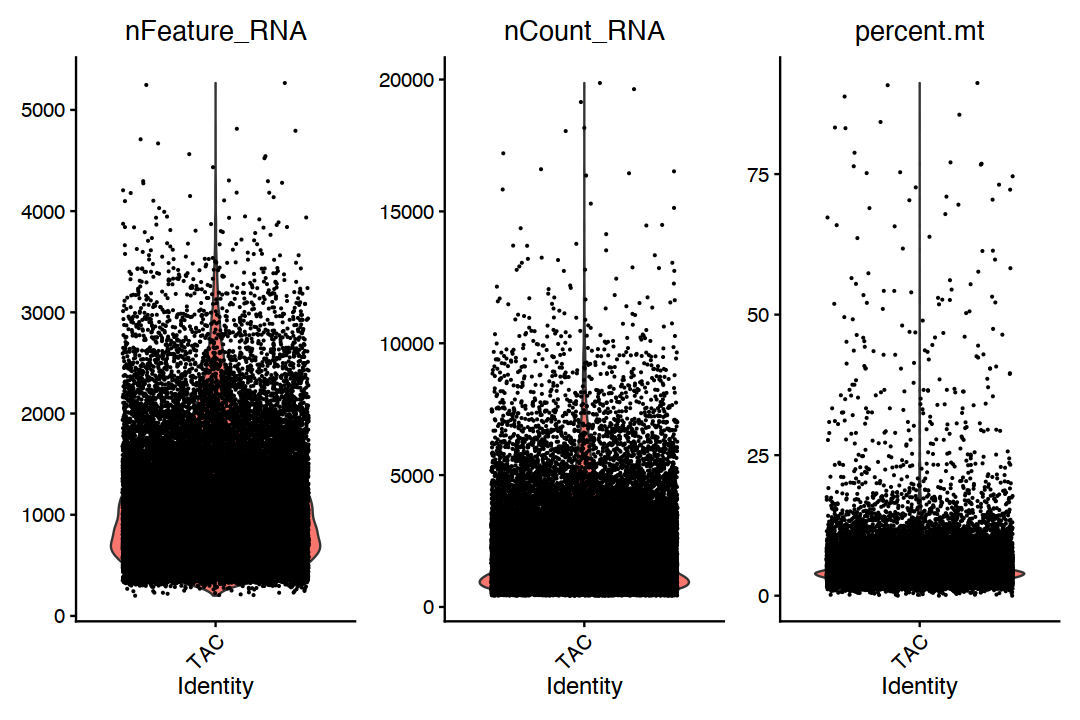

In [4]:
#Violin plot of QC metrics
options(repr.plot.width=9, repr.plot.height=6)
VlnPlot(genes.seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

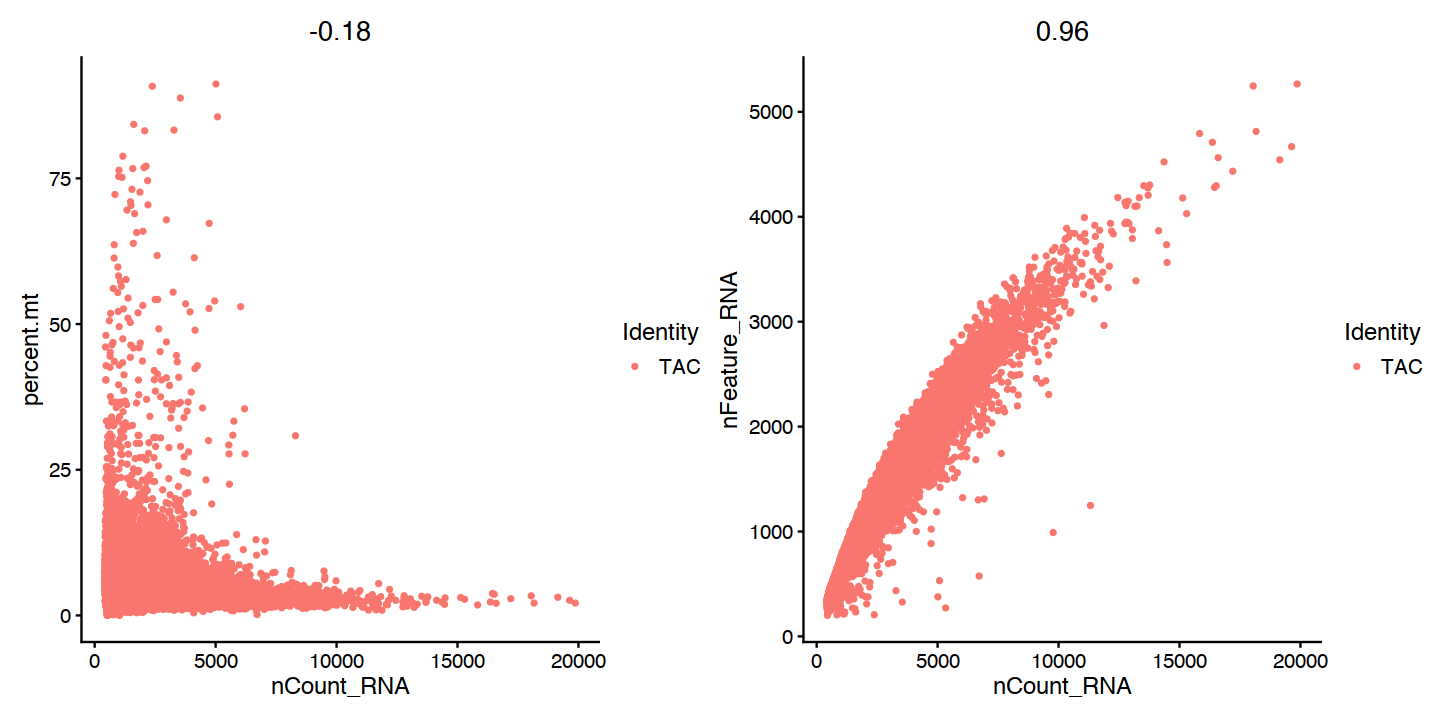

In [6]:
options(repr.plot.width=12, repr.plot.height=6)

plot1 <- FeatureScatter(genes.seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(genes.seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [7]:
genes.seurat <- subset(genes.seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 3000 & percent.mt < 10 &
                         nCount_RNA > 500 & nCount_RNA < 10000)
dim(genes.seurat)

# Normalise data
genes.seurat <- NormalizeData(object = genes.seurat, 
                              normalization.method = "LogNormalize", 
                              scale.factor = 10000)

# Find higly variable genes
genes.seurat <- FindVariableFeatures(object = genes.seurat, mean.function = "vst", nfeatures = 3000)

# Regress of unwanted variation
genes.seurat <- ScaleData(genes.seurat, 
                          vars.to.regress = c("nCount_RNA", "Experiment"), 
                          verbose = TRUE)

genes.seurat <- RunPCA(object = genes.seurat, features = VariableFeatures(object = genes.seurat), npcs=60)

## Clustering
genes.seurat <- FindNeighbors(genes.seurat, dims = 1:25)
genes.seurat <- FindClusters(genes.seurat, resolution = seq(0.4, 1.2, 0.2))

Idents(genes.seurat) <- genes.seurat@meta.data$RNA_snn_res.0.6

### UMAP/t-SNE analysis
genes.seurat <- RunUMAP(genes.seurat, dims = 1:25)


[1] 15945 26726

Regressing out nCount_RNA, Experiment

Centering and scaling data matrix

PC_ 1 
Positive:  Fcer1g, Tyrobp, C1qb, C1qa, C1qc, Lyz2, Ctss, Ctsc, Fcgr3, Alox5ap 
	   Pf4, C5ar1, Wfdc17, Cd14, Csf1r, F13a1, Ms4a6c, Cd53, Ccl6, Mrc1 
	   Laptm5, Aif1, Lcp1, Fcgr2b, Lgmn, Ccl9, Ms4a6b, Adgre1, Ms4a7, Cd74 
Negative:  Igfbp7, Serpinh1, Sparc, Bgn, Dcn, Col3a1, Mfap5, Col1a2, Serping1, Fstl1 
	   Lhfp, Pcolce, Mgp, Lum, Pi16, Ltbp4, Gsn, Ccdc80, Col1a1, Col8a1 
	   Aspn, Ogn, Sparcl1, Pam, Cygb, Sdc2, Loxl1, Rbp1, Fbln2, Smoc2 
PC_ 2 
Positive:  Fabp4, Cd36, Cavin2, Gpihbp1, Cav1, Ly6c1, Tspan13, Rgcc, Egfl7, Cdh5 
	   Cav2, Tcf15, Id1, Gng11, Slc9a3r2, Esam, Kdr, Flt1, Aqp1, Mgll 
	   Pecam1, Emcn, Ctla2a, Adgrl4, AW112010, Adgrf5, Cyyr1, Timp4, Kitl, Gimap6 
Negative:  Lgals1, Gsn, Dcn, Cfh, Timp2, Lum, Gpx3, Serping1, Col3a1, Mfap5 
	   Col1a2, Htra3, Ogn, Bgn, Smoc2, Ftl1, Cebpb, Serpinf1, Igfbp4, Ifi27l2a 
	   Dpt, Pcolce, Emp3, Clec3b, Dpep1, Pmp22, Loxl1, Col1a1, Fbln1, Pi16 
PC_ 3 
Po

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26726
Number of edges: 908699

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9186
Number of communities: 19
Elapsed time: 4 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26726
Number of edges: 908699

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8975
Number of communities: 23
Elapsed time: 4 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26726
Number of edges: 908699

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8812
Number of communities: 26
Elapsed time: 4 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26726
Number of edges: 908699

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8698
Number of communities: 29
Elapsed time: 4 seconds
Modularity O

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:09:45 UMAP embedding parameters a = 0.9922 b = 1.112

20:09:45 Read 26726 rows and found 25 numeric columns

20:09:45 Using Annoy for neighbor search, n_neighbors = 30

20:09:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:09:47 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//RtmpwNGolr/file181db3cf42d08

20:09:47 Searching Annoy index using 1 thread, search_k = 3000

20:09:53 Annoy recall = 100%

20:09:53 Commencing smooth kNN distance calibr

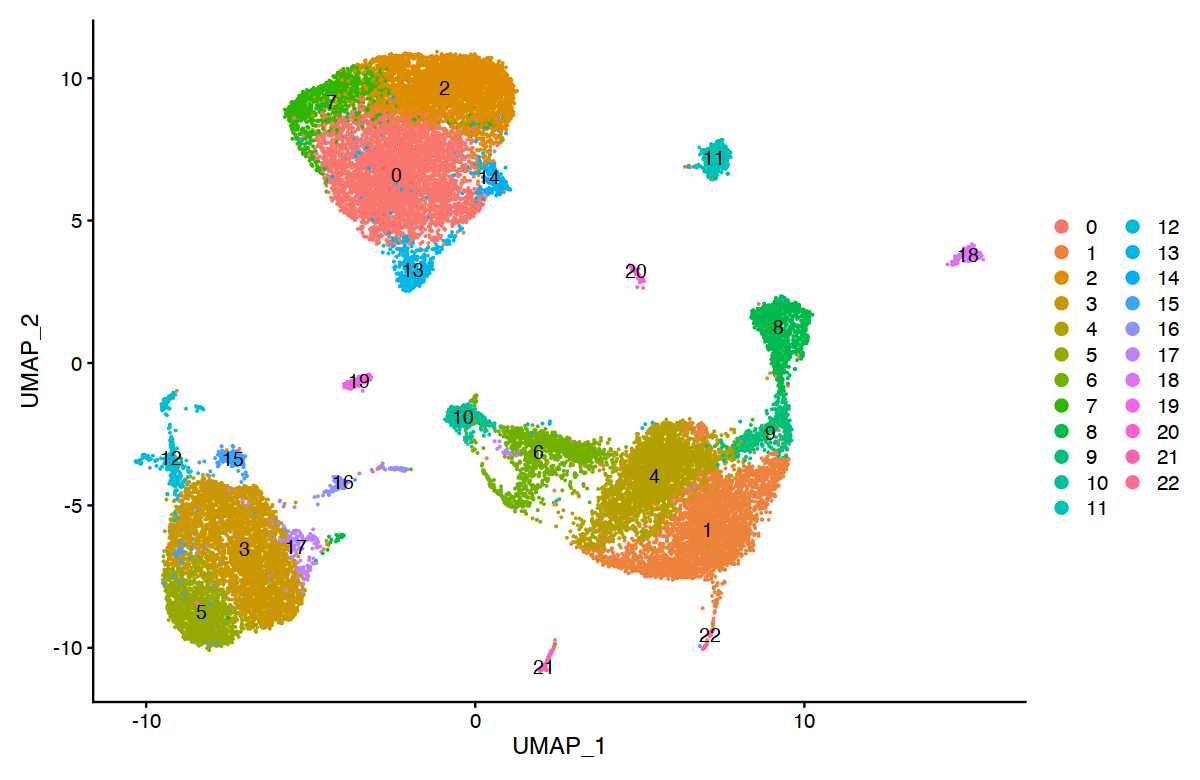

In [8]:
options(repr.plot.width=10, repr.plot.height=6.5)
DimPlot(genes.seurat, reduction = "umap", label = TRUE)

# Doublet filtering

Visualise and filter doublets identified with Scrublet

[1] "Predicted singlets from Scrublet: 28802"
[1] "Overlap with filtered data: 25837"


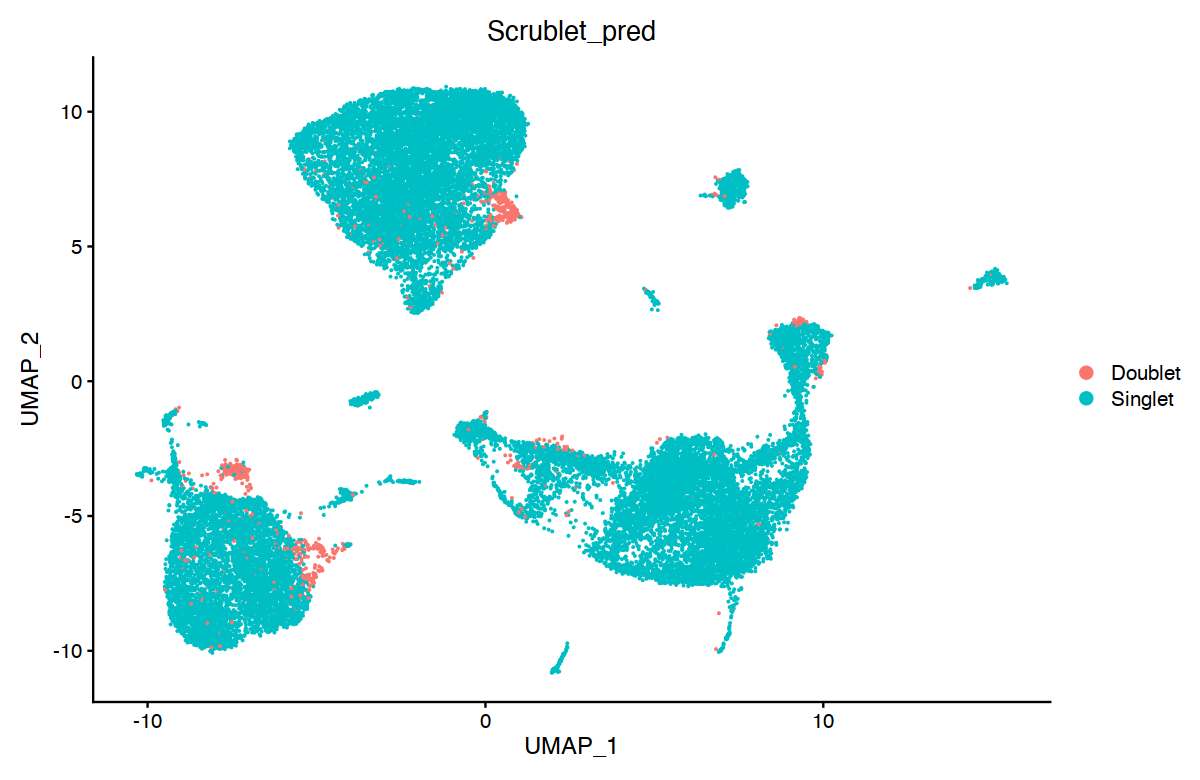

In [9]:
singlet.files <- c("Scrublet/Sham_rep1_singlets.txt",
                   "Scrublet/Sham_rep2_singlets.txt",
                   "Scrublet/TAC_rep1_singlets.txt",
                   "Scrublet/TAC_rep2_singlets.txt")

all.singlets <- c()
for (this.file in singlet.files) {
  singlets <- readLines(this.file)
  all.singlets <- append(all.singlets, singlets)
}
print(paste("Predicted singlets from Scrublet:", length(all.singlets)))
print(paste("Overlap with filtered data:", length(intersect(colnames(genes.seurat), all.singlets))))

scrublet.doublet <- ifelse(colnames(genes.seurat) %in% all.singlets, "Singlet", "Doublet")
genes.seurat@meta.data$Scrublet_pred <- scrublet.doublet

options(repr.plot.width=10, repr.plot.height=6.5)
DimPlot(genes.seurat, group.by = "Scrublet_pred")

In [10]:
# Filter the Seurat object for the singlets
genes.seurat <- subset(genes.seurat, Scrublet_pred == "Singlet")
dim(genes.seurat)

# Normalise data
genes.seurat <- NormalizeData(object = genes.seurat, 
                              normalization.method = "LogNormalize", 
                              scale.factor = 10000)

# Find higly variable genes
genes.seurat <- FindVariableFeatures(object = genes.seurat, mean.function = "vst", nfeatures = 3000)

# Regress of unwanted variation
genes.seurat <- ScaleData(genes.seurat, 
                          vars.to.regress = c("nCount_RNA", "Experiment"), 
                          model.use = "negbinom", 
                          verbose = TRUE)

genes.seurat <- RunPCA(object = genes.seurat, features = VariableFeatures(object = genes.seurat), npcs=60)

## Clustering
genes.seurat <- FindNeighbors(genes.seurat, k.param = 30, dims = 1:30)
genes.seurat <- FindClusters(genes.seurat, resolution = seq(0.2, 0.8, 0.1))

### UMAP/t-SNE analysis
genes.seurat <- RunUMAP(genes.seurat, 
                        n.neighbors = 30, 
                        dims = 1:30,
                        min.dist = 0.2,
                        seed.use = 42)

Idents(genes.seurat) <- genes.seurat@meta.data$RNA_snn_res.0.7


[1] 15945 25837

Regressing out nCount_RNA, Experiment

glm.nb failed for gene S100a8; falling back to scale(log(y+1))

glm.nb failed for gene S100a9; falling back to scale(log(y+1))

Warning message:
“step size truncated due to divergence”
glm.nb failed for gene Saa3; falling back to scale(log(y+1))

Warning message:
“step size truncated due to divergence”
glm.nb failed for gene Slpi; falling back to scale(log(y+1))

Warning message:
“step size truncated due to divergence”
glm.nb failed for gene Alox15; falling back to scale(log(y+1))

Warning message:
“step size truncated due to divergence”
glm.nb failed for gene Igkc; falling back to scale(log(y+1))

Warning message:
“step size truncated due to divergence”
glm.nb failed for gene Retnlg; falling back to scale(log(y+1))

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning messag

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in glm.nb(formula = fmla, data = regression.mat):
“alternation limit reached”
Warning message in glm.nb(formula = fmla, data = regression.mat):
“alternation limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, s

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced

Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached

Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in glm.nb(formula = fmla, data = regression.mat):
“alternation limit reached”
glm.nb failed for gene Krt8; falling back to scale(log(y+1))

Warning message in glm.nb(formula = fmla, data = regression.mat):
“alternation limit reached”
Warning message in glm.nb(formula = fmla, data = regression.mat):
“alternation limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in glm.nb(formula = fmla, data = regression.mat):
“alternation limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in glm.nb(formula = fmla, data = regression.mat):
“alternation limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did n

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25837
Number of edges: 1424620

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9512
Number of communities: 14
Elapsed time: 3787 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25837
Number of edges: 1424620

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9337
Number of communities: 15
Elapsed time: 6 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25837
Number of edges: 1424620

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9203
Number of communities: 15
Elapsed time: 5 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25837
Number of edges: 1424620

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9087
Number of communities: 18
Elapsed time: 3807 seconds
Mo

01:26:59 UMAP embedding parameters a = 1.262 b = 1.003

01:26:59 Read 25837 rows and found 30 numeric columns

01:26:59 Using Annoy for neighbor search, n_neighbors = 30

01:26:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

01:27:01 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//RtmpwNGolr/file181db7ada81c1

01:27:01 Searching Annoy index using 1 thread, search_k = 3000

01:27:06 Annoy recall = 100%

01:27:06 Commencing smooth kNN distance calibration using 1 thread

01:27:07 Initializing from normalized Laplacian + noise

01:27:08 Commencing optimization for 200 epochs, with 1096884 positive edges

01:27:21 Optimization finished



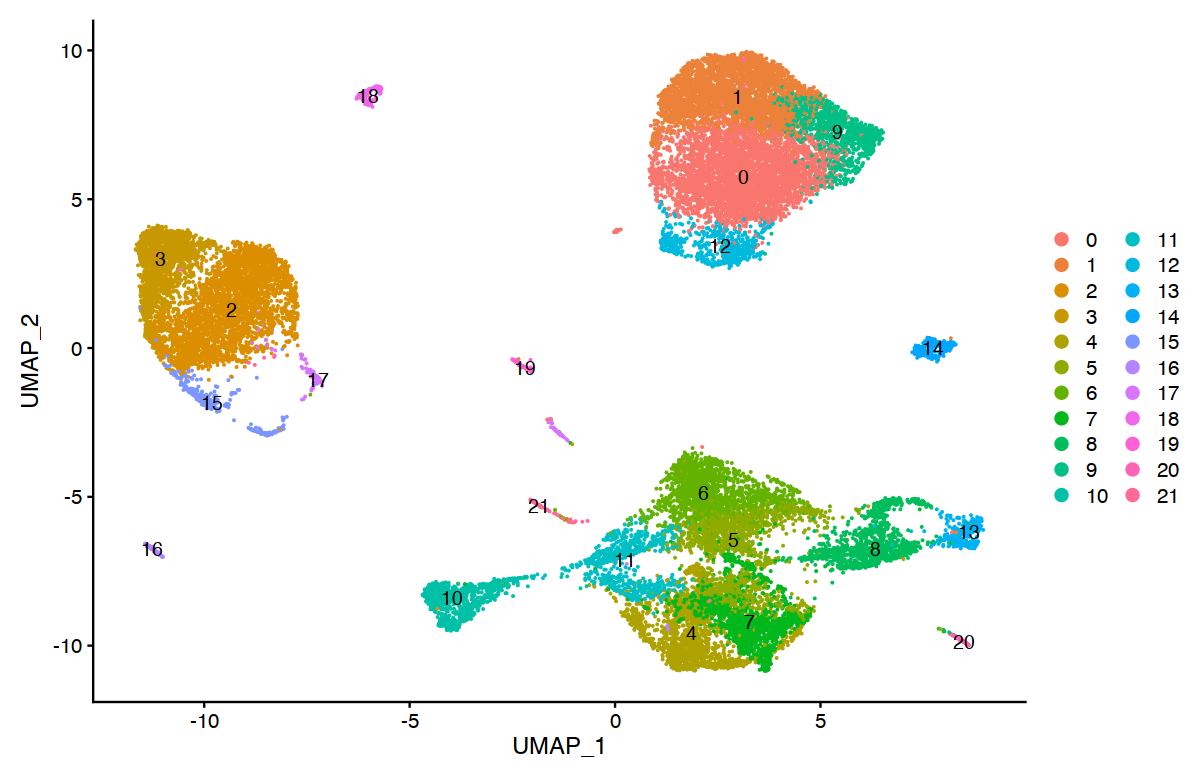

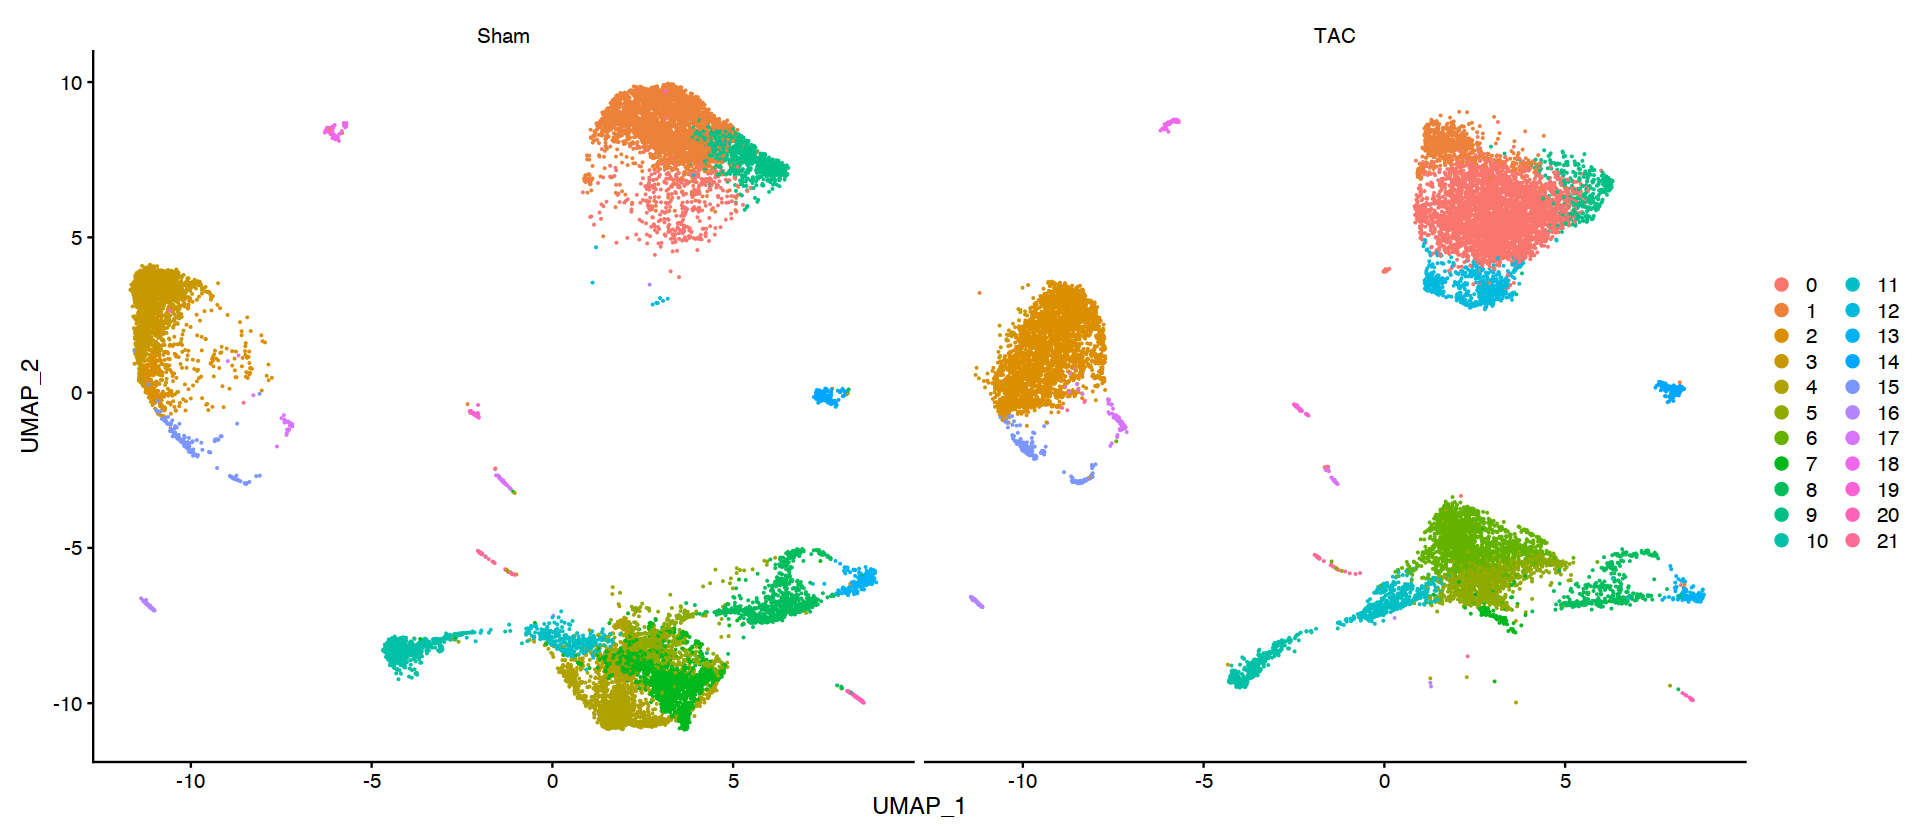

In [11]:
DimPlot(genes.seurat, reduction = "umap", label = TRUE)
options(repr.plot.width=16, repr.plot.height=7)
DimPlot(genes.seurat, reduction = "umap", split.by = "Condition", ncol=2)

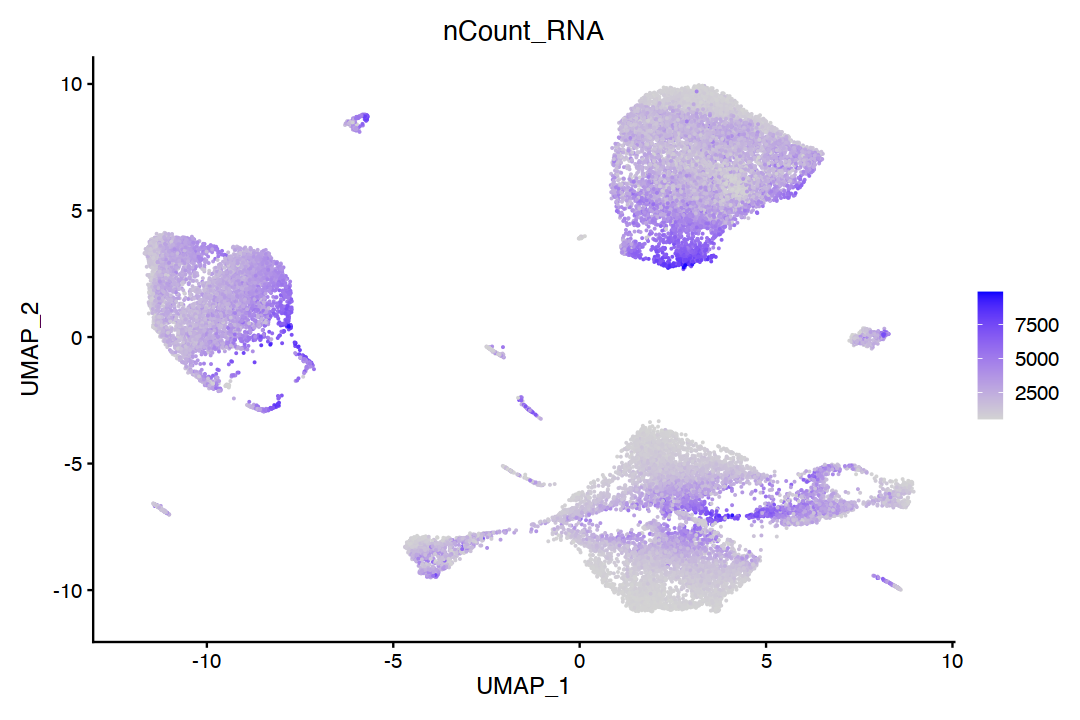

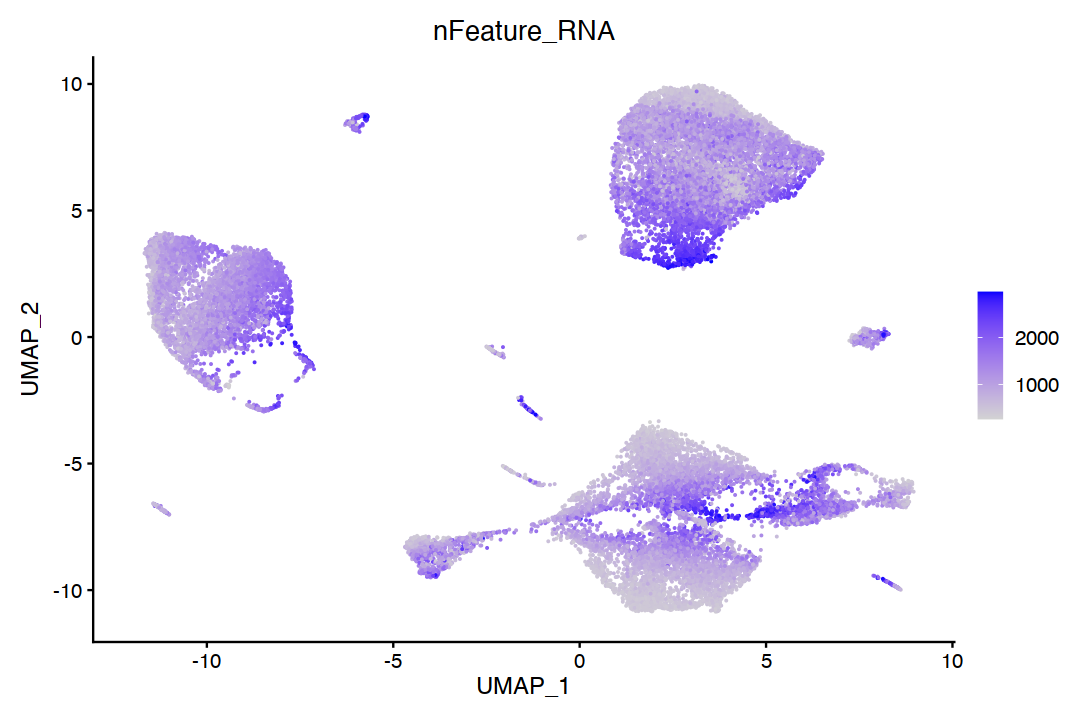

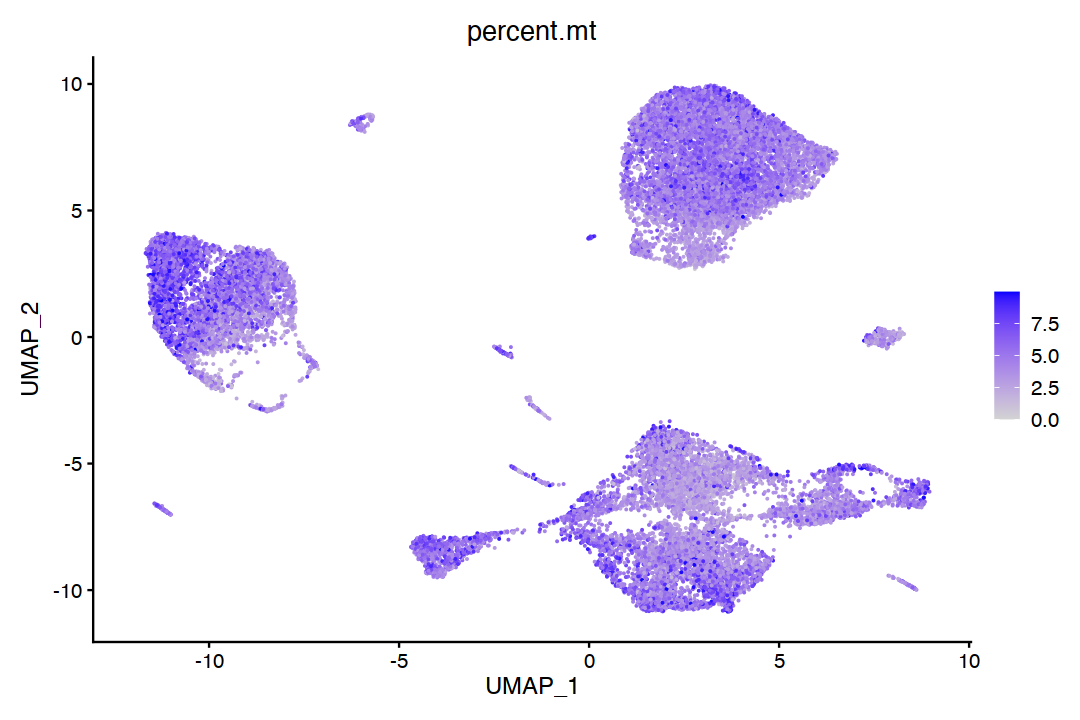

In [12]:
options(repr.plot.width=9, repr.plot.height=6)
FeaturePlot(genes.seurat, "nCount_RNA")
FeaturePlot(genes.seurat, "nFeature_RNA")
FeaturePlot(genes.seurat, "percent.mt")

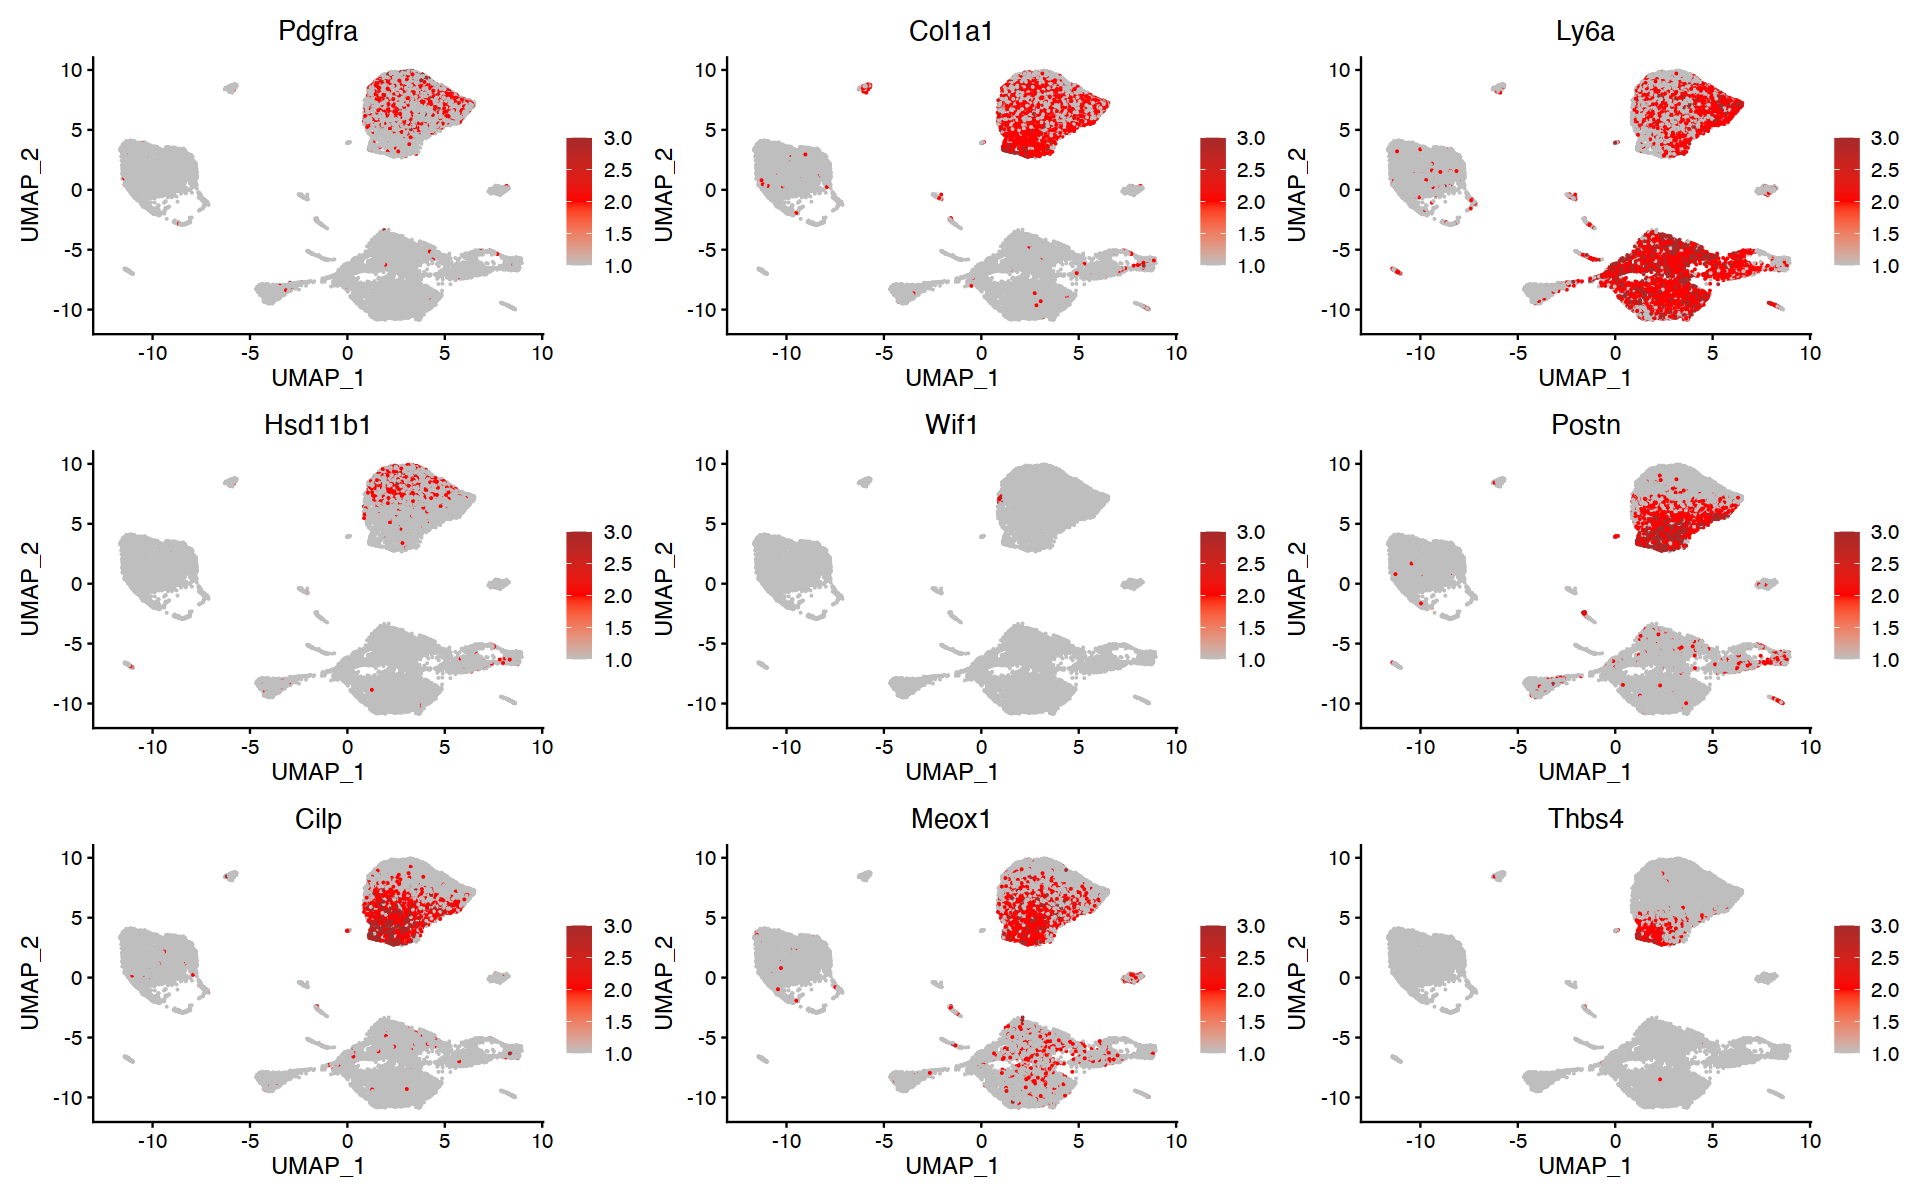

In [13]:
options(repr.plot.width=16, repr.plot.height=10)
FeaturePlot(genes.seurat, c("Pdgfra", "Col1a1", "Ly6a", "Hsd11b1", "Wif1",
                            "Postn", "Cilp", "Meox1", "Thbs4"), 
            cols = c("grey", "red", "brown"))

# Select fibroblasts

Will subset fibroblasts - clusters 0, 1, 9 and 12. 

[1] 15945  9512

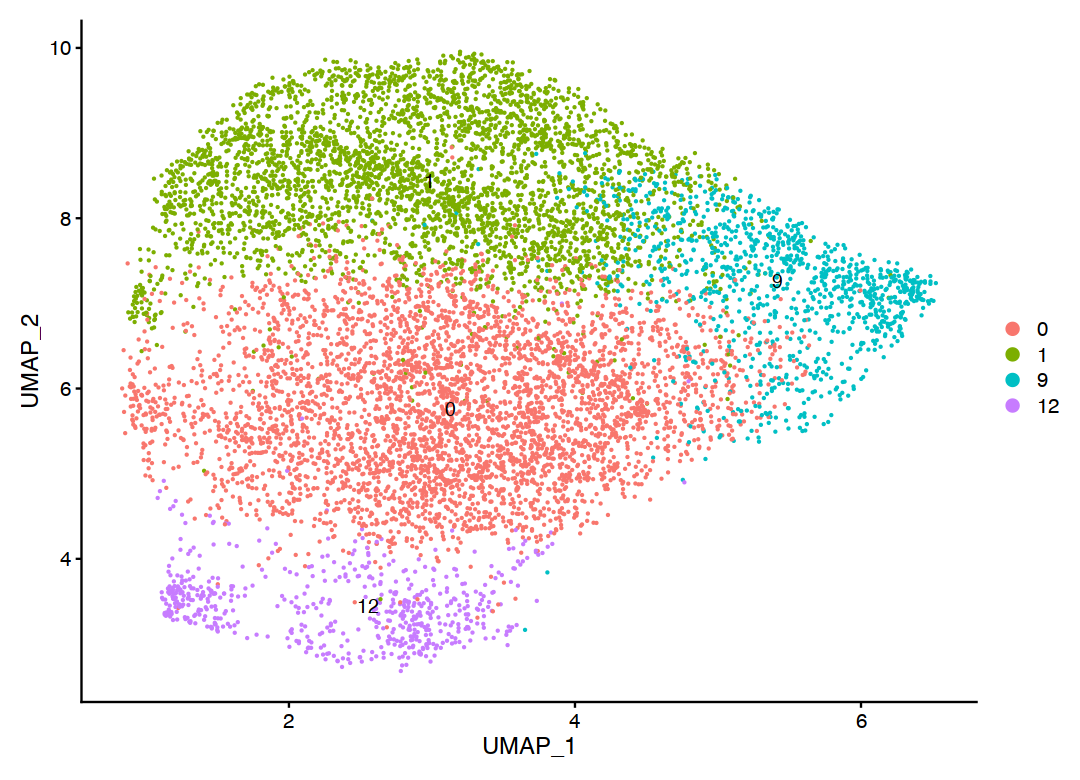

In [15]:
fibro.clusters <- c("0", "1", "9", "12")

fibroblasts.seurat <- subset(genes.seurat, idents = fibro.clusters)
dim(fibroblasts.seurat)

fibroblasts.seurat <- subset(fibroblasts.seurat, UMAP_1 > 0.5 )
fibroblasts.seurat <- subset(fibroblasts.seurat, UMAP_2 > 1.5 )

options(repr.plot.width=9, repr.plot.height=6.5)
DimPlot(fibroblasts.seurat, label = TRUE)

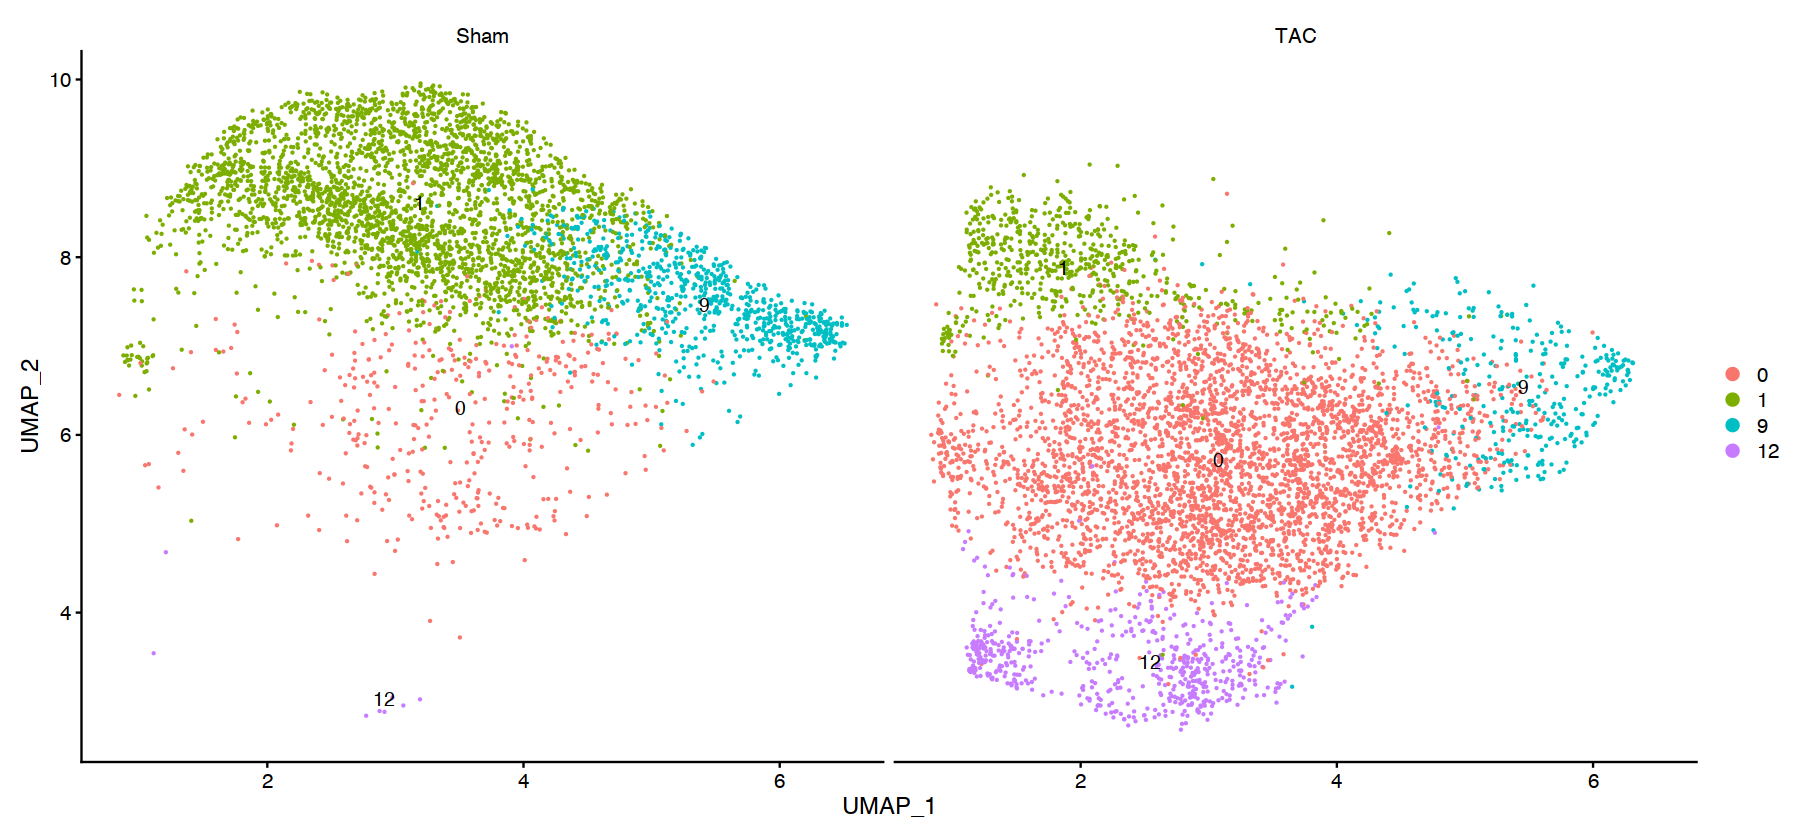

In [18]:
options(repr.plot.width=15, repr.plot.height=7) 
DimPlot(fibroblasts.seurat, label = TRUE, split.by = "Condition", ncol = 2)

# Session information

In [19]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] en_AU.UTF-8/en_AU.UTF-8/en_AU.UTF-8/C/en_AU.UTF-8/en_AU.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Matrix_1.3-4       dplyr_1.0.7        plyr_1.8.6         SeuratObject_4.0.2
[5] Seurat_4.0.3       ggplot2_3.3.5     

loaded via a namespace (and not attached):
  [1] nlme_3.1-152          spatstat.sparse_2.0-0 matrixStats_0.60.0   
  [4] RcppAnnoy_0.0.19      RColorBrewer_1.1-2    httr_1.4.2           
  [7] repr_1.1.3            sctransform_0.3.2     tools_4.1.0          
 [10] utf8_1.2.2            R6_2.5.0              irlba_2.3.3          
 [13] rpart_4.1-15          KernSmooth_2.23-20 